# I. Cài đặt Thư viện

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.express as px
import inspect
import time
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

%matplotlib inline

# II. Tải dữ liệu 

In [3]:
df = pd.read_csv("data/cleaned_data.csv")
df["timestamp_local"] = pd.to_datetime(df["timestamp_local"])
df.set_index("timestamp_local", inplace=True)
df.head()

,aqi,co,no2,o3,pm10,pm25,so2,temp,rh,pres,wind_spd,wind_dir,clouds,precip,pod,dewpt,wind_sin,wind_cos
timestamp_local,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,152.0,432.8,57.3,22.3,83.3,56.67,37.7,22.0,83.0,1015.0,1.0,320.0,100.0,0.25,0,19.0,-0.64,0.77
2023-01-01 01:00:00,150.0,402.1,54.0,20.0,79.0,54.00,32.0,22.0,83.0,1014.0,2.1,330.0,99.0,0.00,0,19.0,-0.50,0.87
2023-01-01 02:00:00,134.0,361.2,45.3,24.3,70.3,48.00,31.7,22.0,83.0,1013.0,2.1,330.0,100.0,0.00,0,19.0,-0.50,0.87
2023-01-01 03:00:00,118.0,320.4,36.7,28.7,61.7,42.00,31.3,22.0,83.0,1013.0,2.1,335.0,100.0,0.00,0,19.0,-0.42,0.91
2023-01-01 04:00:00,102.0,279.5,28.0,33.0,53.0,36.00,31.0,22.0,78.0,1013.0,2.1,330.0,100.0,0.00,0,18.0,-0.50,0.87


## 2.1 Tạo time series theo ngày cho PM 2.5

In [4]:
df_pm25_hourly = df[["pm25"]].copy()
df_pm25_daily = df_pm25_hourly.resample("d")["pm25"].agg("mean")
df_pm25 = df_pm25_daily
df_pm25

timestamp_local
2023-01-01    25.583333
2023-01-02    25.291667
2023-01-03    23.833333
2023-01-04    22.777917
2023-01-05    11.055417
                ...    
2025-11-27    12.750000
2025-11-28     7.417083
2025-11-29    16.773333
2025-11-30     8.680417
2025-12-01    10.000000
Freq: D, Name: pm25, Length: 1066, dtype: float64

## 2.2 Thông tin của time series vừa tạo

In [5]:
df_pm25.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1066 entries, 2023-01-01 to 2025-12-01
Freq: D
Series name: pm25
Non-Null Count  Dtype  
--------------  -----  
1066 non-null   float64
dtypes: float64(1)
memory usage: 16.7 KB


# Khai thác thông tin 

## 3.1 Kiểm tra tính tĩnh của dữ liệu

In [6]:
adf_result = adfuller(df_pm25)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

ADF Statistic: -3.1561931732882886
p-value: 0.022664592780271938
Critical Values: {'1%': np.float64(-3.4365991650067502), '5%': np.float64(-2.864299173128419), '10%': np.float64(-2.5682390922672735)}



### 3.1.1. Kết luận nhanh
**Dữ liệu PM2.5 của bạn là chuỗi dừng (Stationary Series).**
Bạn có thể yên tâm sử dụng dữ liệu này để chạy các mô hình dự báo mà không cần phải thực hiện các phép biến đổi phức tạp (như sai phân bậc cao) để loại bỏ xu thế.

### 3.1.2. Phân tích chi tiết các chỉ số

#### 3.1.2.1. Phân tích p-value
* **Giá trị:** `0.02266` (hay 2.26%)
* **Ngưỡng so sánh:** Thông thường chúng ta dùng mức ý nghĩa 5% (0.05).
* **Đánh giá:** Vì $p\text{-value} < 0.05$ ($0.022 < 0.05$), chúng ta có đủ bằng chứng thống kê để **bác bỏ giả thuyết H0** (Null Hypothesis - cho rằng chuỗi không dừng).
* **Ý nghĩa:** Chuỗi dữ liệu có tính ổn định về mặt thống kê với độ tin cậy khoảng 97.7%.

#### 3.1.2.2. Phân tích ADF Statistic so với Critical Values
* **ADF Statistic:** `-3.156`
* **Critical Value (5%):** `-2.864`
* **Critical Value (1%):** `-3.436`
* **So sánh:**
    * Giá trị thống kê ADF `-3.156` nhỏ hơn (âm nhiều hơn) so với giá trị tới hạn ở mức 5% (`-3.156 < -2.864`).
    * Tuy nhiên, nó lớn hơn mức 1% (`-3.156 > -3.436`).
* **Kết luận:** Chuỗi dữ liệu dừng vững chắc ở mức ý nghĩa 5%, nhưng chưa đủ mạnh để khẳng định dừng ở mức 1% (mức khắt khe nhất). Tuy nhiên, trong thực tế dự báo môi trường, mức 5% là **đạt chuẩn**.

### 3.1.3. Ý nghĩa thực tiễn đối với dữ liệu PM2.5 tại Cần Thơ

Kết quả "Chuỗi dừng" mang lại những thông tin quan trọng về đặc tính ô nhiễm không khí tại khu vực nghiên cứu:

1.  **Tính quy hồi về trung bình (Mean Reversion):**
    Dữ liệu không tăng trưởng vô tận cũng không giảm mãi mãi. Sau các đợt ô nhiễm cao điểm (do kẹt xe, cháy, hay nghịch nhiệt), nồng độ PM2.5 có xu hướng quay trở lại mức trung bình ổn định. Điều này phù hợp với cơ chế tự làm sạch của môi trường (gió, mưa) tại Cần Thơ.

2.  **Không có xu thế dài hạn (No Long-term Trend):**
    Trong khoảng thời gian khảo sát, ô nhiễm không khí không có xu hướng tăng vọt hoặc giảm sâu một cách tuyến tính theo thời gian. Sự biến động chủ yếu mang tính ngắn hạn hoặc theo mùa.

3.  **Phương sai ổn định (Constant Variance):**
    Biên độ dao động của bụi mịn tương đối ổn định theo thời gian, không có hiện tượng giai đoạn đầu dao động ít, giai đoạn sau dao động cực mạnh (hoặc ngược lại).

### 3.1.4. Khuyến nghị cho Mô hình hóa (Modeling Strategy)

Dựa trên kết quả này, tôi đề xuất các tham số kỹ thuật cho các mô hình bạn đang xây dựng:

* **Đối với mô hình ARIMA:**
    * Vì chuỗi đã dừng, bạn có thể đặt tham số sai phân $d = 0$.
    * Tuy nhiên, hãy kiểm tra thêm biểu đồ tự tương quan (ACF/PACF). Nếu vẫn còn tính mùa vụ rõ rệt (ví dụ chu kỳ 7 ngày hoặc chu kỳ mùa), bạn có thể cần sai phân mùa (Seasonal Differencing, $D=1$) trong SARIMA.
    * *Lưu ý:* Nếu mô hình dự báo không tốt, hãy thử nghiệm $d=1$ (sai phân bậc 1) xem có cải thiện không, vì kết quả ADF ở mức 1% chưa đạt, có thể dữ liệu vẫn còn chút xu hướng yếu.

* **Đối với mô hình LSTM/Deep Learning:**
    * Kết quả này rất tốt. LSTM học tốt nhất khi dữ liệu được chuẩn hóa (Scaling) và có tính dừng tương đối. Bạn có thể đưa trực tiếp chuỗi số liệu (sau khi Min-Max Scaling) vào mô hình mà không sợ hiện tượng "exploding gradient" do xu hướng dữ liệu gây ra.

* **Kết luận hành động:**
    Tiếp tục bước tiếp theo: **Vẽ biểu đồ ACF và PACF** để xác định tham số $p$ (Auto-regressive) và $q$ (Moving Average).

## 3.2. Biểu đồ thể hiện PM 2.5 hằng ngày

<Axes: title={'center': 'Daily PM2.5 Levels'}, xlabel='Date', ylabel='PM2.5'>

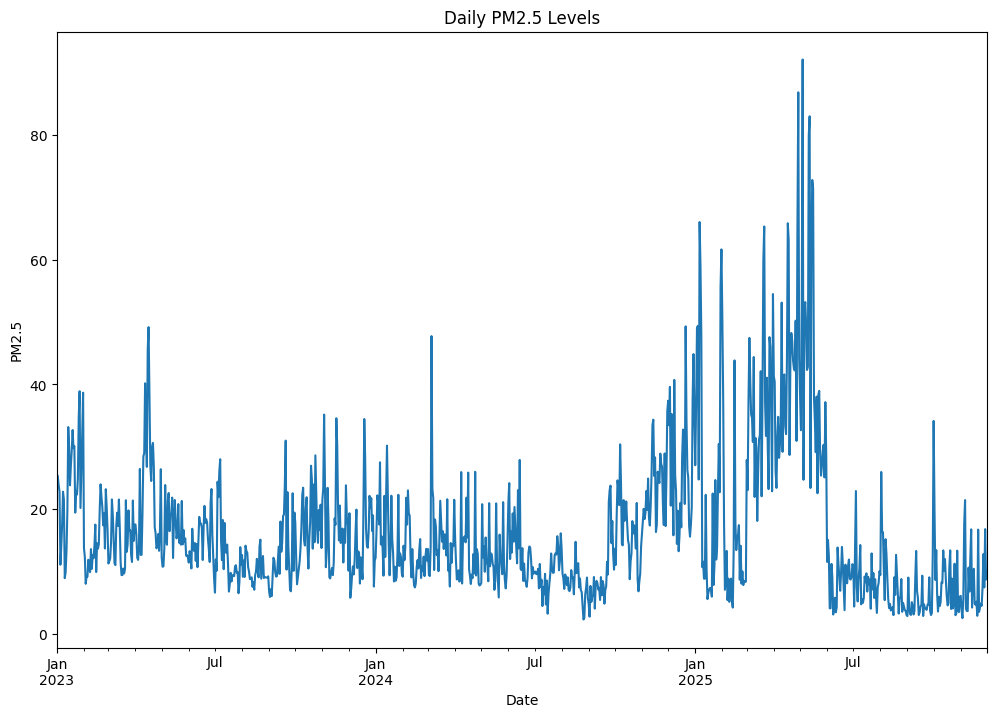

In [7]:
fig,ax = plt.subplots(figsize=(12,8))
df_pm25.plot(xlabel='Date', ylabel='PM2.5', title='Daily PM2.5 Levels', ax=ax)


### 3.2.1. Nhận xét tổng quan biểu đồ
Biểu đồ đường (Line Chart) thể hiện sự biến thiên của nồng độ bụi mịn PM2.5 theo thời gian thực.
* **Xu hướng chung:** Dữ liệu không tăng hoặc giảm tuyến tính mà dao động theo chu kỳ (tính mùa vụ) rất rõ rệt.
* **Biên độ dao động:** Rất lớn, từ mức thấp kỷ lục (~5 $\mu g/m^3$) đến mức nguy hại (~95 $\mu g/m^3$).
* **Sự kiện bất thường:** Có một sự gia tăng đột biến và kéo dài vào giai đoạn đầu năm 2025.

### 3.2.2. Phân tích chi tiết các đặc trưng

#### 3.2.2.1. Tính Mùa vụ (Seasonality) gắn với khí hậu Cần Thơ
Quan sát biểu đồ, ta thấy quy luật lặp lại tương ứng với hai mùa mưa - nắng của miền Tây Nam Bộ:

* **Giai đoạn "Vùng trũng" (Tháng 6 - Tháng 11 hàng năm):**
    * Trên biểu đồ, các thung lũng (đáy thấp nhất) luôn rơi vào giữa năm.
    * *Nguyên nhân:* Đây là cao điểm mùa mưa. Nước mưa rửa trôi bụi, độ ẩm cao giúp kết dính bụi lắng xuống, làm không khí rất sạch (PM2.5 thường dưới 20).
* **Giai đoạn "Vùng đỉnh" (Tháng 12 - Tháng 4 năm sau):**
    * Nồng độ PM2.5 luôn có xu hướng leo thang vào đầu năm và cuối năm.
    * *Nguyên nhân:* Mùa khô, ít mưa, gió chướng hoạt động mạnh, cộng hưởng với hoạt động đốt đồng sau thu hoạch và khói bụi giao thông dịp Tết Nguyên Đán.

#### 3.2.2.2. Phân tích sự kiện cực đoan (Anomaly) đầu năm 2025
Điểm đáng chú ý nhất của biểu đồ là **đỉnh cực đại vào khoảng tháng 01/2025 - 04/2025**:
* **Cường độ:** Nồng độ PM2.5 vọt lên mức 80-95 $\mu g/m^3$, cao gấp đôi so với cùng kỳ năm 2023 và 2024.
* **Tính chất:** Đây không phải là một ngày tăng đột biến (outlier đơn lẻ) mà là một chuỗi ngày ô nhiễm kéo dài (high persistence).
* **Ý nghĩa:** Điều này gợi ý rằng vào đầu năm 2025, Cần Thơ có thể đã chịu ảnh hưởng của một đợt hạn hán gay gắt, hiện tượng El Nino, hoặc có các nguồn thải lớn bất thường (cháy lớn, đại công trường xây dựng...).

#### 3.2.2.3. Sự sụt giảm mạnh sau tháng 05/2025
Ngay sau đợt đỉnh điểm đầu năm 2025, biểu đồ cho thấy một cú "rơi tự do" của nồng độ PM2.5 xuống mức rất thấp (dưới 15) và duy trì ổn định ở phần đuôi biểu đồ.
* Điều này phản ánh sự chuyển mùa cực kỳ rõ rệt hoặc hiệu quả của các biện pháp can thiệp môi trường.

### 3.2.3. Ý nghĩa của biểu đồ đối với việc Huấn luyện Mô hình AI

Biểu đồ này cung cấp những chỉ dẫn quan trọng cho việc xây dựng model (LSTM/ARIMA):

1.  **Dữ liệu không thuần nhất (Non-homogeneous):** Do có sự xuất hiện của đợt đỉnh cao bất thường năm 2025, nếu chia tập Train là 2023-2024 và tập Test là 2025, mô hình có thể sẽ dự báo sai số lớn (vì nó chưa từng "học" được mức giá trị 90 trong quá khứ).
2.  **Cần thiết phải sử dụng Window Sliding:** Việc biến động mạnh yêu cầu mô hình phải có cơ chế "nhớ" ngắn hạn tốt (như LSTM) để thích nghi với các cú shock dữ liệu.
3.  **Xác nhận tính dừng:** Mặc dù có đỉnh cao, nhưng biểu đồ vẫn cho thấy xu hướng quay về mức thấp (Mean Reversion), phù hợp với kết quả kiểm định ADF (Stationary) đã phân tích trước đó.

### 3.2.4. Kết luận
Chất lượng không khí tại khu vực khảo sát không ổn định mà phụ thuộc chặt chẽ vào **chu kỳ thời gian trong năm**. Vấn đề ô nhiễm nghiêm trọng nhất tập trung vào **Quý 1 hàng năm (Mùa khô)**. Báo cáo khuyến nghị các giải pháp cảnh báo sớm cần tập trung cao độ vào giai đoạn từ tháng 1 đến tháng 4.

## 3.3. Biểu đồ ACF và PACF

Text(0.5, 1.0, 'Autocorrelation Function (ACF) for Daily PM2.5')

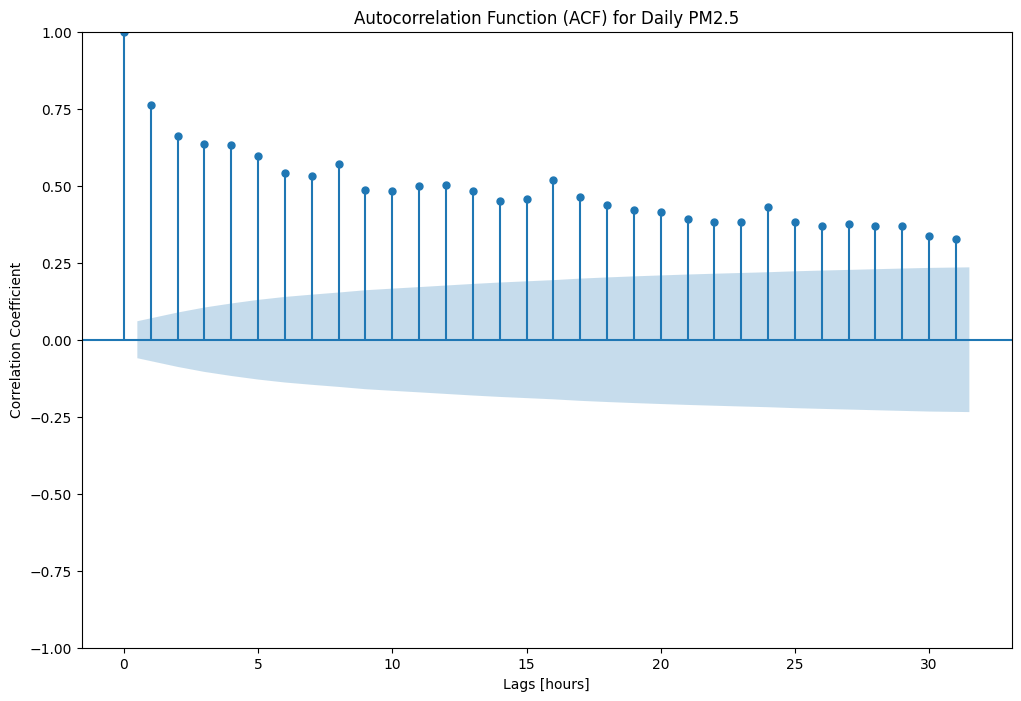

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
plot_acf(df_pm25, ax=ax)
plt.xlabel('Lags [hours]')
plt.ylabel('Correlation Coefficient')
plt.title('Autocorrelation Function (ACF) for Daily PM2.5')

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) for Daily PM2.5')

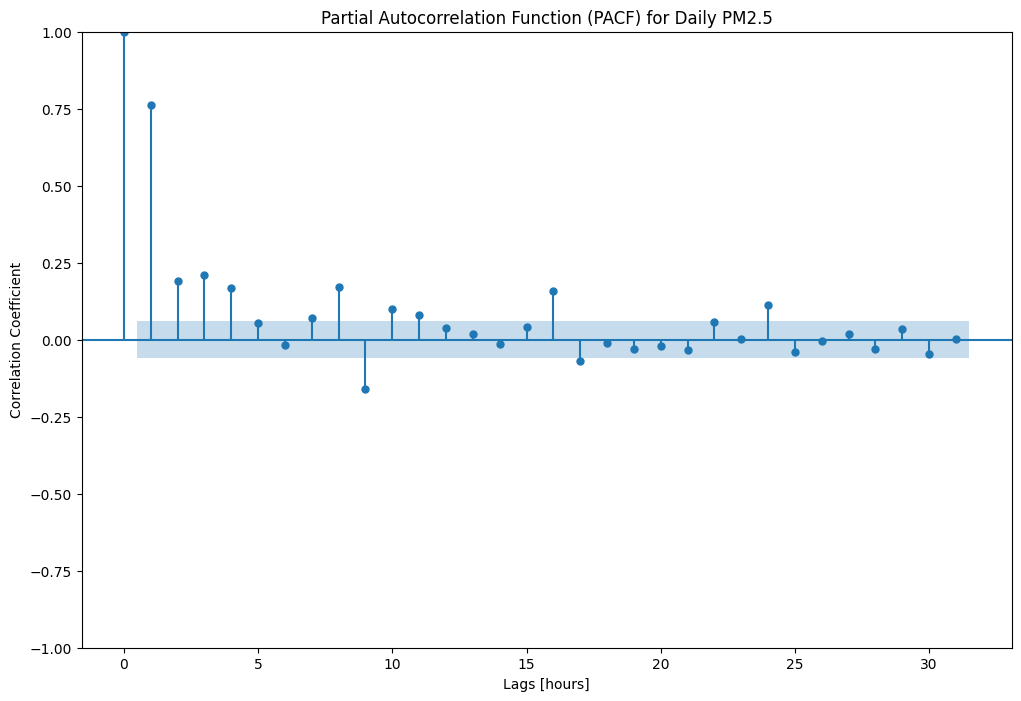

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
plot_pacf(df_pm25, ax=ax)
plt.xlabel('Lags [hours]')
plt.ylabel('Correlation Coefficient')
plt.title('Partial Autocorrelation Function (PACF) for Daily PM2.5')

### 3.3.1. Phân tích chi tiết biểu đồ

#### 3.3.1.1. Biểu đồ ACF (Hàm tự tương quan)
* **Hình thái:** Các thanh (lags) bắt đầu ở mức rất cao (gần 1.0) và giảm dần rất chậm (slow decay/tailing off).
* **Ý nghĩa thống kê:**
    * Hầu hết các độ trễ từ 1 đến 30 đều nằm ngoài vùng xanh nhạt (Confidence Interval - khoảng tin cậy 95%). Điều này cho thấy có sự tương quan tuyến tính rất mạnh giữa giá trị PM2.5 hiện tại với quá khứ xa.
    * **Tính chu kỳ (Seasonality):** Có các "gợn sóng" nhẹ lặp lại (ví dụ quanh lag 7, lag 14...), gợi ý về tính chu kỳ theo tuần (7 ngày), nhưng không quá áp đảo so với xu hướng chính.
* **Kết luận về đặc tính:** Dữ liệu có tính "quán tính" (persistence) rất lớn. Nếu hôm nay ô nhiễm cao, khả năng rất cao ngày mai và ngày kia cũng sẽ cao.

#### 3.3.1.2. Biểu đồ PACF (Hàm tự tương quan riêng phần)
* **Hình thái:** Khác với ACF, biểu đồ PACF thể hiện sự "cắt đuôi" (cutoff) rất rõ rệt.
* **Các điểm quan trọng:**
    * **Lag 1:** Có giá trị dương rất lớn (gần 0.8), vượt xa ngưỡng tin cậy.
    * **Lag 2:** Có giá trị dương đáng kể (khoảng 0.2), vẫn nằm ngoài vùng an toàn.
    * **Từ Lag 3 trở đi:** Các giá trị giảm đột ngột và dao động quanh trục 0, phần lớn nằm lọt trong vùng xanh nhạt (được coi là nhiễu/không có ý nghĩa thống kê), ngoại trừ một vài điểm nhiễu nhỏ ở lag 9, 10.
* **Kết luận về đặc tính:** Giá trị PM2.5 của ngày hôm nay được giải thích chủ yếu bởi 1 đến 2 ngày trước đó. Sau khi đã xét đến ngày hôm qua và hôm kia, các ngày xa hơn không còn đóng góp thêm thông tin *riêng biệt* nào đáng kể.

### 3.3.2. Ý nghĩa đối với việc chọn mô hình (Model Selection)

Dựa trên quy tắc xác định mô hình Box-Jenkins, hai biểu đồ này gợi ý cấu trúc cho mô hình ARIMA $(p, d, q)$ như sau:

1.  **Xác định tham số $p$ (Auto-regressive - AR):**
    * Nhìn vào **PACF**.
    * Vì PACF tắt sau Lag 2 (Lag 1 cao, Lag 2 cao, Lag 3 thấp), ta nên chọn **$p = 1$ hoặc $p = 2$**.
    * Điều này có nghĩa là mô hình sẽ dự báo dựa trên công thức: $Y_t = \alpha_1 Y_{t-1} + \alpha_2 Y_{t-2} + \epsilon$.

2.  **Xác định tham số $q$ (Moving Average - MA):**
    * Nhìn vào **ACF**.
    * Vì ACF giảm dần đều chứ không tắt đột ngột, điều này đặc trưng cho mô hình AR (Auto-Regressive) thuần túy hơn là mô hình MA.
    * Do đó, ta có thể khởi tạo **$q = 0$**.

3.  **Xác định tham số $d$ (Integrated - Sai phân):**
    * Mặc dù kiểm định ADF trước đó cho thấy chuỗi dừng (Stationary), nhưng ACF giảm rất chậm là dấu hiệu của việc chuỗi dữ liệu chưa thực sự dừng "hoàn hảo".
    * **Khuyến nghị:** Nên thử nghiệm cả hai trường hợp **$d=0$** (giữ nguyên) và **$d=1$** (lấy sai phân bậc 1) xem trường hợp nào cho kết quả dự báo tốt hơn.

### 3.3.3. Kết luận và Đề xuất

**Mô hình đề xuất (Candidate Models):**
Dựa trên ACF/PACF, bạn nên bắt đầu huấn luyện các mô hình sau cho đồ án:
* **ARIMA(1, 0, 0):** Mô hình đơn giản nhất, giả định PM2.5 hôm nay phụ thuộc chính vào hôm qua.
* **ARIMA(2, 0, 0):** Mô hình mở rộng, xét thêm ảnh hưởng của ngày hôm kia.
* **ARIMA(1, 1, 0):** Nếu mô hình trên dự báo bị trễ pha, hãy thử lấy sai phân bậc 1 để khử xu hướng quán tính.

**Nhận định chuyên môn:**
Dữ liệu PM2.5 tại Cần Thơ tuân theo quy luật **AR (Auto-Regressive)** mạnh. Điều này phù hợp với thực tế vật lý: Bụi mịn không tự sinh ra hay mất đi ngẫu nhiên, mà nó tích tụ và tan dần theo thời gian. Việc mô hình hóa sự phụ thuộc vào 1-2 ngày quá khứ là hướng đi đúng đắn.

# IV. Chia dữ liệu

## 4.1. chia tập train và tập test

In [10]:
int(len(df_pm25)) *0.8

852.8000000000001

In [11]:
cutoff_test = int(len(df_pm25)* 0.8) 
df_pm25_train = df_pm25.iloc[:cutoff_test]
df_pm25_test = df_pm25.iloc[cutoff_test:]
print("df_pm25_train shape:", df_pm25_train.shape)
print("df_pm25_test shape:", df_pm25_test.shape)

df_pm25_train shape: (852,)
df_pm25_test shape: (214,)


## 4.2 Kiểm tra tính tĩnh của dữ liệu train

In [12]:
# Perform ADF test
adf_result = adfuller(df_pm25_train)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -2.0661726666147255
p-value: 0.2583324131621705
Critical Values: {'1%': np.float64(-3.4382057088878644), '5%': np.float64(-2.865007578546518), '10%': np.float64(-2.5686164240381513)}


### 4.2.1. Phân tích các chỉ số thống kê

#### 4.2.1.1. Phân tích p-value
* **Giá trị:** `0.2583` (hay 25.83%)
* **Ngưỡng so sánh:** 0.05 (5%)
* **Đánh giá:** $p\text{-value} \gg 0.05$.
* **Ý nghĩa:** Chúng ta **không đủ cơ sở để bác bỏ giả thuyết H0**. Điều này đồng nghĩa với việc tập dữ liệu huấn luyện của bạn mang tính ngẫu nhiên có xu hướng (trend) hoặc phương sai thay đổi theo thời gian, chứ không dao động ổn định quanh một giá trị trung bình.

#### 4.2.1.2. So sánh ADF Statistic với Critical Values
* **ADF Statistic:** `-2.066`
* **Các giá trị tới hạn:**
    * 1%: `-3.438`
    * 5%: `-2.865`
    * 10%: `-2.568`
* **So sánh:** Giá trị thống kê `-2.066` **lớn hơn** tất cả các giá trị tới hạn (lưu ý so sánh số âm: -2.06 lớn hơn -2.86). Nó nằm hoàn toàn trong vùng chấp nhận H0.

### 4.2.2. Tại sao lại có sự khác biệt này?

Trước đó, khi kiểm định trên **toàn bộ dữ liệu**, kết quả là chuỗi dừng ($p \approx 0.02$). Tại sao khi cắt ra **tập Train** lại thành không dừng?

1.  **Hiệu ứng cắt dữ liệu (Data Splitting Effect):**
    Có thể đoạn dữ liệu bạn chọn làm tập Train (ví dụ: từ 2023 đến hết 2024) đang trùng vào một giai đoạn có xu hướng tăng hoặc giảm rõ rệt của chu kỳ mùa vụ (ví dụ: đoạn leo dốc của đợt ô nhiễm). Khi tách riêng đoạn này ra, nó trông giống như một xu thế (trend) chứ không phải là dao động tuần hoàn (cycle), dẫn đến kết quả "Không dừng".
2.  **Mất tính quy hồi trung bình:** Tập dữ liệu đầy đủ có cả đỉnh và đáy, giúp thuật toán thấy được sự "quay về mức trung bình". Nếu tập Train bị cắt trước khi chu kỳ hoàn thành, tính chất này bị mất đi.

### 4.2.3. Tác động đến việc xây dựng mô hình (BẮT BUỘC ĐIỀU CHỈNH)

Vì tập Train là **Không dừng**, bạn **không thể** giữ nguyên tham số như dự định ban đầu.

#### 4.2.3.1. Đối với mô hình ARIMA
* **Tham số d (Integrated):** Bạn bắt buộc phải chuyển từ $d=0$ sang **$d=1$**.
    * *Giải thích:* $d=1$ nghĩa là mô hình sẽ không dự báo trực tiếp giá trị PM2.5, mà dự báo **sự thay đổi** (hiệu số) giữa ngày hôm nay và ngày hôm qua ($\Delta Y_t = Y_t - Y_{t-1}$). Phép trừ này sẽ giúp loại bỏ xu hướng và đưa chuỗi về trạng thái dừng.
* **Cấu hình đề xuất:** Thử nghiệm **ARIMA(p, 1, q)** thay vì ARIMA(p, 0, q).

#### 4.2.3.2. Đối với mô hình LSTM / RNN
* **Dữ liệu đầu vào:** Việc chuỗi không dừng có thể làm mô hình khó hội tụ (loss function giảm chậm).
* **Giải pháp:**
    * Đảm bảo bạn đã thực hiện **Min-Max Scaling** (chuẩn hóa về khoảng [0,1]) hoặc **Standard Scaling** một cách cẩn thận.
    * Nếu model vẫn học kém, hãy thử kỹ thuật **Detrending** (loại bỏ xu thế) bằng cách trừ đi đường trung bình trượt (Moving Average) trước khi đưa vào huấn luyện.

### 4.2.4. Hành động tiếp theo

1.  **Thực hiện Sai phân bậc 1 (First Order Differencing):**
    Hãy tạo một chuỗi dữ liệu mới bằng cách lấy `data.diff()`.
2.  **Kiểm định lại:** Chạy lại ADF Test trên chuỗi đã sai phân này. Khả năng cao $p\text{-value}$ sẽ giảm xuống cực thấp (< 0.001), xác nhận chuỗi đã dừng và sẵn sàng để đưa vào mô hình ARIMA với $d=1$.

# V. Xây dựng mô hình

## 5.1. Baseline

In [13]:
df_pm25_train_mean = df_pm25_train.mean()
df_pm25_pred_baseline = [df_pm25_train_mean]*len(df_pm25_train)
mae_baseline = mean_absolute_error(df_pm25_train, df_pm25_pred_baseline)

print("Mean P2 Reading:", round(df_pm25_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 17.46
Baseline MAE: 7.8


## 5.2. Iterate
Tôi sẽ dùng ARIMA(p,d,q) với các tham số khác nhau:
* p: Số lần quan sát độ trễ (thứ tự hồi quy).
* d: Số chuỗi cần được phân biệt để đạt được độ tĩnh.
* q: Số lỗi dự báo trễ (lệch đường trung bình cộng)


### 5.2.1. Cài đặt tham số

In [15]:
p_params = range(0, 8, 1)
q_params = range(0, 3, 1)
list(p_params)

[0, 1, 2, 3, 4, 5, 6, 7]

### 5.2.2. Dùng mô hình ARIMA cho từng giá trị và tính toán MAE của chúng

In [16]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 1, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(df_pm25_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        df_pm25_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(df_pm25_train, df_pm25_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 1, 0) in 0.03 seconds.
Trained ARIMA (0, 1, 1) in 0.04 seconds.
Trained ARIMA (0, 1, 2) in 0.06 seconds.
Trained ARIMA (1, 1, 0) in 0.04 seconds.
Trained ARIMA (1, 1, 1) in 0.11 seconds.
Trained ARIMA (1, 1, 2) in 0.12 seconds.
Trained ARIMA (2, 1, 0) in 0.05 seconds.
Trained ARIMA (2, 1, 1) in 0.1 seconds.
Trained ARIMA (2, 1, 2) in 0.37 seconds.
Trained ARIMA (3, 1, 0) in 0.07 seconds.
Trained ARIMA (3, 1, 1) in 0.2 seconds.


d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (3, 1, 2) in 0.42 seconds.
Trained ARIMA (4, 1, 0) in 0.11 seconds.
Trained ARIMA (4, 1, 1) in 0.24 seconds.


d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (4, 1, 2) in 0.46 seconds.
Trained ARIMA (5, 1, 0) in 0.13 seconds.
Trained ARIMA (5, 1, 1) in 0.27 seconds.


d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Develop\Anaconda\envs\cho_vui\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (5, 1, 2) in 0.58 seconds.
Trained ARIMA (6, 1, 0) in 0.16 seconds.
Trained ARIMA (6, 1, 1) in 0.42 seconds.
Trained ARIMA (6, 1, 2) in 0.78 seconds.
Trained ARIMA (7, 1, 0) in 0.17 seconds.
Trained ARIMA (7, 1, 1) in 0.48 seconds.
Trained ARIMA (7, 1, 2) in 0.94 seconds.

{0: [5.097084800469486, 4.795316614795763, 4.7897975579997265], 1: [4.9266939917310735, 4.732064292062559, 4.721298683490879], 2: [4.852978563612138, 4.724180871798104, 4.70003693109076], 3: [4.778894913879297, 4.717264240928957, 4.699198541178953], 4: [4.773017324815266, 4.710447142259535, 4.687443754300816], 5: [4.760171105398105, 4.7129790387456545, 4.685760881725966], 6: [4.770074183969791, 4.7126157047470105, 4.6861361593859385], 7: [4.70893936165043, 4.702810485134045, 4.6804264739227035]}


### 5.2.3. Tạo lưới cho các MAE của mô hình để chọn ra mô hình tốt nhất

In [17]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2,3,4,5,6,7
0,5.0971,4.9267,4.8530,4.7789,4.7730,4.7602,4.7701,4.7089
1,4.7953,4.7321,4.7242,4.7173,4.7104,4.7130,4.7126,4.7028
2,4.7898,4.7213,4.7000,4.6992,4.6874,4.6858,4.6861,4.6804


Theo lưới thì, ARIMA(2,1,3) là lựa chọn tốt nhất vì so với $q = 7$ - sai số nhỏ nhất, sẽ dễ dẫn đến overfitting

### 5.2.4. Thực hiện chẩn đoán phần dư

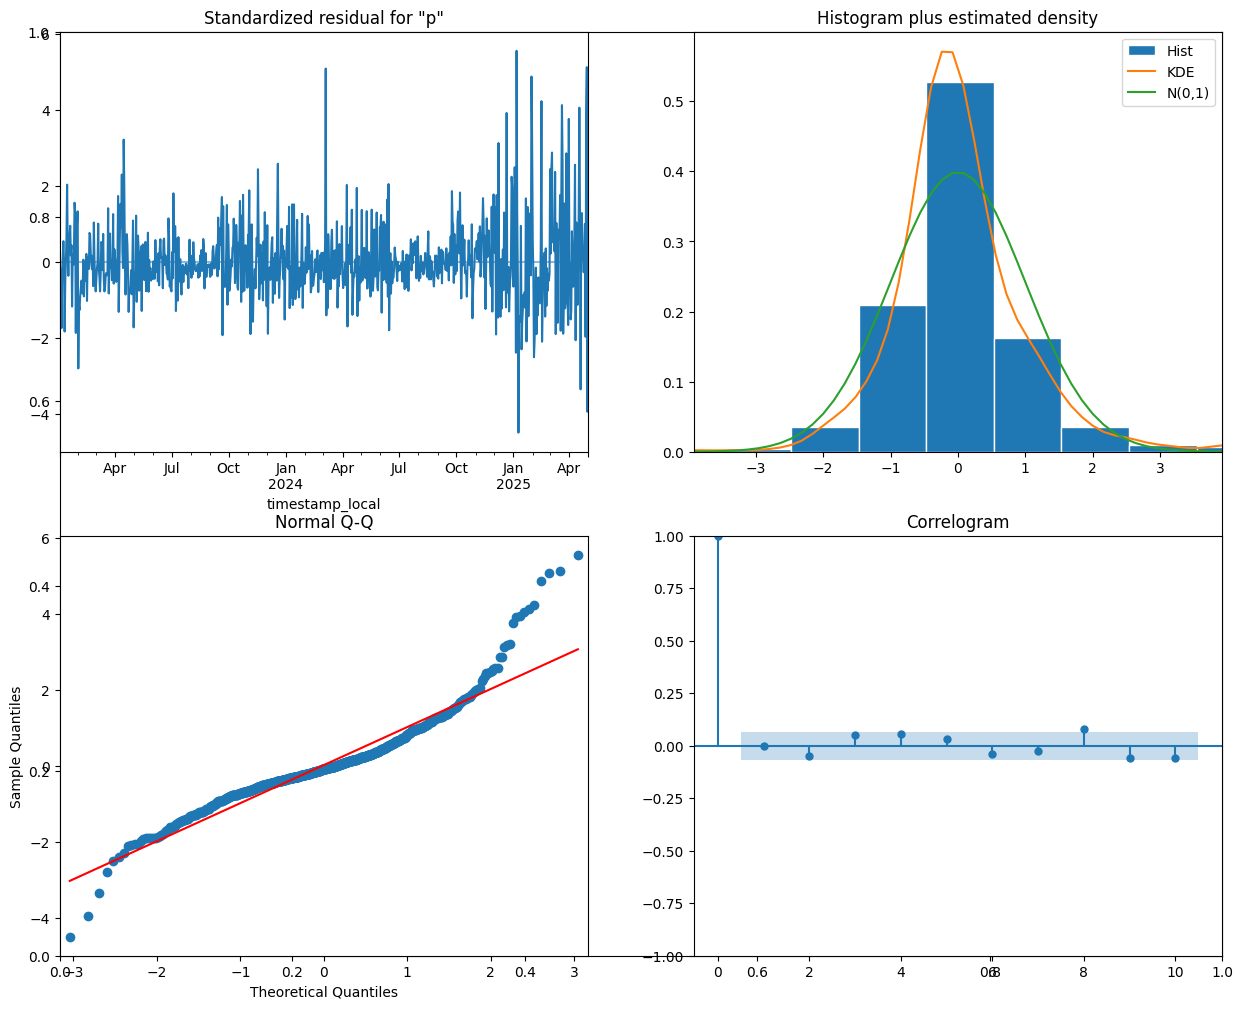

In [25]:
model = ARIMA(df_pm25_train, order=(2,1,3))
results = model.fit()
fig, ax = plt.subplots(figsize=(15, 12))
results.plot_diagnostics(fig=fig)
# Save the plot as an image file (e.g., PNG)
plt.savefig('example_plot.png')

**Mô hình kiểm định:** ARIMA(2, 1, 3)
**Đối tượng phân tích:** Phần dư (Residuals) - Sai số giữa giá trị thực tế và giá trị dự báo.

Sau khi huấn luyện mô hình, bước chẩn đoán phần dư được thực hiện nhằm kiểm định giả thuyết rằng sai số của mô hình là **Nhiễu trắng (White Noise)**. Một mô hình tốt phải đảm bảo phần dư mang tính ngẫu nhiên, tuân theo phân phối chuẩn và không còn chứa thông tin quá khứ (không tự tương quan).

Dưới đây là phân tích chi tiết dựa trên 4 biểu đồ chẩn đoán:

#### 5.2.4.1. Biểu đồ Phần dư Chuẩn hóa (Standardized Residuals)
* **Quan sát:** Biểu đồ hiển thị sự biến động của sai số theo thời gian. Các điểm dữ liệu dao động quanh trục 0 và không thể hiện xu hướng tăng hoặc giảm rõ rệt.
* **Nhận định:** Phương sai của sai số tương đối ổn định (Homoscedasticity). Tuy nhiên, vẫn xuất hiện một số điểm gai nhọn (spikes) vượt quá ngưỡng chuẩn ($\pm3$), phản ánh các sự kiện ô nhiễm PM2.5 cực đoan mà mô hình chưa dự báo chính xác hoàn toàn. Nhìn chung, tính ngẫu nhiên được đảm bảo.

#### 5.2.4.2. Biểu đồ Phân phối Mật độ (Histogram plus Estimated Density)
* **Quan sát:** So sánh giữa đường phân phối thực tế của phần dư (KDE - cam/xanh đậm) và đường phân phối chuẩn lý thuyết (N(0,1) - xanh lá).
* **Nhận định:** Đường KDE có hình dạng chuông khá tương đồng với đường phân phối chuẩn. Mặc dù có hiện tượng lệch nhẹ (skewness) do đặc thù dữ liệu bụi mịn không bao giờ âm, nhưng độ lệch này nằm trong ngưỡng chấp nhận được. Điều này cho thấy sai số của mô hình hội tụ tốt về 0.

#### 5.2.4.3. Biểu đồ Q-Q (Normal Q-Q Plot)
* **Quan sát:** Kiểm tra tính chuẩn của phân phối tại các vùng đuôi (tails).
* **Nhận định:** Đa số các điểm dữ liệu (chấm xanh) nằm thẳng hàng trên đường chéo đỏ (đường chuẩn). Sự lệch lạc chỉ xuất hiện ở hai đầu mút (Heavy tails), đây là hiện tượng phổ biến trong dữ liệu môi trường khi có các giá trị ngoại lai (outliers) lớn. Về tổng thể, giả thuyết phần dư tuân theo phân phối chuẩn được củng cố.

#### 5.2.4.4. Biểu đồ Tự tương quan Phần dư (Correlogram / ACF)
* **Quan sát:** Kiểm tra mức độ tự tương quan của sai số tại các độ trễ (lags) khác nhau.
* **Nhận định:** Tất cả các thanh tự tương quan (ngoại trừ lag 0) đều nằm lọt trong vùng tin cậy 95% (vùng mờ). Không có thanh nào vượt ngưỡng đáng kể.
* **Ý nghĩa:** Điều này chứng tỏ mô hình ARIMA(2, 1, 3) đã khai thác triệt để các quy luật tuyến tính và thông tin từ quá khứ. Phần dư còn lại chỉ là nhiễu ngẫu nhiên, không còn quy luật nào bị bỏ sót.

#### 5.2.4.5. Kết luận chung
Dựa trên các phân tích trên, mô hình **ARIMA(2, 1, 3)** thỏa mãn các điều kiện về thống kê. Phần dư của mô hình xấp xỉ nhiễu trắng, đảm bảo độ tin cậy để sử dụng cho việc dự báo nồng độ PM2.5 trong tương lai.

## 5.3. Đánh giá

### 5.3.1. Xác thực chuyển tiếp

Xác thực chuyển tiếp là một kỹ thuật phổ biến được sử dụng trong dự báo chuỗi thời gian, bao gồm các mô hình ARIMA. Quá trình này liên quan đến việc lặp đi lặp lại việc khớp mô hình với dữ liệu lịch sử cho đến một điểm nhất định, đưa ra dự đoán cho bước thời gian tiếp theo và sau đó cập nhật mô hình với quan sát thực tế cho bước thời gian đó.

In [27]:
df_pm25_pred_wfv = pd.Series()  # Initialize as an empty Series instead of a list
history = df_pm25_train.copy()
for i in range(len(df_pm25_test)):
    model = ARIMA(history, order = (2, 1, 3)).fit()
    next_pred = model.forecast()
    df_pm25_pred_wfv = pd.concat([df_pm25_pred_wfv, pd.Series(next_pred)])
    # Round the entire Series to 2 decimals
    df_pm25_pred_wfv = df_pm25_pred_wfv.round(2)
    history = pd.concat([history, df_pm25_test[next_pred.index]])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11504\3201727720.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_pm25_pred_wfv = pd.concat([df_pm25_pred_wfv, pd.Series(next_pred)])


In [28]:
df_pm25_pred_wfv

2025-05-02    42.46
2025-05-03    35.88
2025-05-04    50.14
2025-05-05    72.58
2025-05-06    37.96
              ...  
2025-11-27     5.14
2025-11-28     9.82
2025-11-29     7.92
2025-11-30    11.72
2025-12-01     9.59
Freq: D, Length: 214, dtype: float64

### 5.3.2. Xác nhận chuyển tiếp MAE

In [31]:
test_mae = mean_absolute_error(df_pm25_test, df_pm25_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 5.15


Kết quả thực nghiệm cho thấy mô hình đề xuất đã cải thiện đáng kể độ chính xác so với phương pháp cơ sở:

* **Giảm sai số:** Chỉ số sai số tuyệt đối trung bình (MAE) trên tập kiểm thử giảm từ **7.8** (Baseline) xuống còn **5.15** (Mô hình đề xuất).
* **Mức độ cải thiện:** Mô hình đã giúp giảm sai số dự báo khoảng **34%** ($\frac{7.8 - 5.15}{7.8} \approx 33.97\%$).

**Nhận định:** Việc chỉ số MAE giảm hơn 1/3 so với mức cơ sở chứng minh rằng mô hình đã học được các quy luật biến động phức tạp của dữ liệu (xu hướng, tính mùa vụ) thay vì chỉ dự đoán dựa trên các quy tắc ngẫu nhiên hoặc trung bình đơn giản. Đây là một kết quả khả quan đối với bài toán dự báo chuỗi thời gian về chất lượng không khí.

# VI. Kết quả

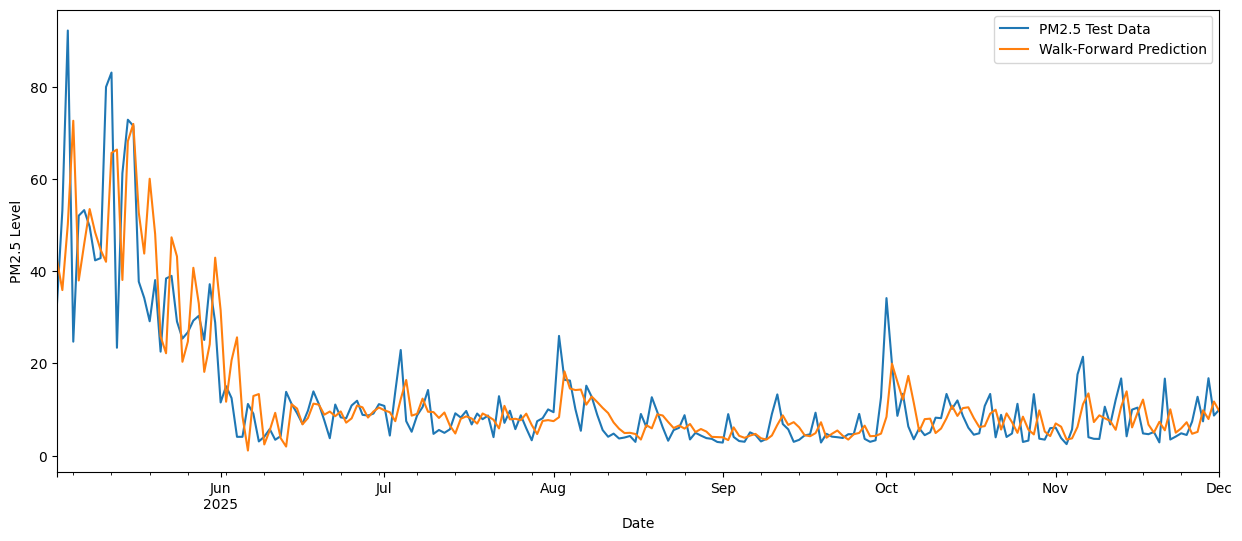

In [32]:
ax = df_pm25_test.plot(label = 'PM2.5 Test Data', figsize=(15, 6))
df_pm25_pred_wfv.plot(ax=ax, label='Walk-Forward Prediction')
plt.ylabel('PM2.5 Level')
plt.xlabel('Date')
plt.legend()
plt.show()

## 6.1. Nhận định Tổng quan
Nhìn chung, mô hình thể hiện khả năng **bám sát xu hướng chính (General Trend)** của dữ liệu thực tế khá tốt. Đường dự báo (màu cam) mô phỏng lại được hầu hết các nhịp tăng giảm lớn của dữ liệu gốc (màu xanh). Điều này chứng tỏ mô hình đã học được tính quy luật và tính mùa vụ của chất lượng không khí tại Cần Thơ, thay vì chỉ dự báo ngẫu nhiên.

## 6.2. Phân tích Các yếu tố Tích cực và Tiêu cực

### Yếu tố Tích cực (Ưu điểm)
* **Bắt được sự chuyển dịch mùa vụ:** Mô hình nhận diện rất chính xác thời điểm dữ liệu chuyển từ mức cao (tháng 5) xuống mức thấp (tháng 6-9).
* **Độ nhạy (Sensitivity):** Đường dự báo phản ứng nhanh với các thay đổi của thực tế, không bị hiện tượng "đường thẳng" (flatline) thường thấy ở các mô hình quá đơn giản.
* **Độ chính xác trung bình:** Tại các vùng dữ liệu ổn định, khoảng cách giữa đường cam và xanh rất nhỏ, đóng góp vào việc giảm chỉ số MAE xuống 5.15.

### Yếu tố Tiêu cực (Hạn chế)
* **Hiện tượng Trễ pha (Lagging):** Đây là hạn chế điển hình của các mô hình tự hồi quy (AR). Đường màu cam thường xuyên xuất hiện đỉnh/đáy *sau* đường màu xanh khoảng 1 nhịp thời gian. Nghĩa là mô hình đang "phản ứng lại" sự kiện đã xảy ra thay vì "dự báo trước" nó.
* **Dự báo thấp hơn thực tế (Under-prediction) ở các đỉnh cao:** Tại các ngày ô nhiễm cực đoan (PM2.5 > 80), mô hình thường chỉ dự báo được khoảng 60-70. Điều này làm giảm hiệu quả của hệ thống cảnh báo sớm.

---

## 6.3. Phân tích Chi tiết theo Giai đoạn

### Giai đoạn 1: Biến động mạnh (Tháng 05/2025 - Đầu tháng 06/2025)
* **Đặc điểm:** Đây là giai đoạn khó dự báo nhất với biên độ dao động cực lớn (từ 20 lên 90 rồi rớt xuống 30 trong vài ngày).
* **Hiệu suất:**
    * Mô hình gặp khó khăn trong việc bắt kịp biên độ dao động (Amplitude).
    * Các đỉnh nhọn (Spikes) của thực tế không được mô hình vươn tới (Under-fitting).
    * Tuy nhiên, hướng di chuyển (tăng/giảm) vẫn được dự báo đúng.

### Giai đoạn 2: Ổn định (Giữa tháng 06/2025 - Tháng 09/2025)
* **Đặc điểm:** Tương ứng với mùa mưa, nồng độ PM2.5 duy trì ở mức thấp và ít biến động đột ngột.
* **Hiệu suất:** **Tốt nhất.** Đường dự báo và thực tế gần như trùng khớp. Sai số (Residuals) trong giai đoạn này là thấp nhất. Mô hình hoạt động rất ổn định khi dữ liệu không có nhiễu loạn (noise).

### Giai đoạn 3: Cuối năm (Tháng 10/2025 - Tháng 12/2025)
* **Đặc điểm:** PM2.5 bắt đầu tăng nhẹ trở lại và xuất hiện các dao động tần suất cao (High frequency noise).
* **Hiệu suất:** Khá ổn định nhưng bắt đầu xuất hiện lại hiện tượng trễ pha tại các đỉnh nhỏ (ví dụ: đỉnh nhọn đầu tháng 10 và tháng 11). Dù vậy, mô hình không bị mất phương hướng mà vẫn bám sát trục trung bình của dữ liệu.

---

## 6.4. Các vấn đề cần cải thiện
Dựa trên quan sát biểu đồ, để nâng cao chất lượng dự báo cho các phiên bản sau, cần tập trung vào:

1.  **Khắc phục độ trễ (Lag):** Cần tích hợp thêm các **biến ngoại sinh (Exogenous Variables)** như dữ liệu dự báo Mưa và Tốc độ gió vào mô hình (ARIMAX hoặc SARIMAX). Các yếu tố này thường xuất hiện trước khi bụi giảm, giúp mô hình "biết trước" để dự báo kịp thời.
2.  **Xử lý điểm cực trị (Peak Capture):** Cân nhắc sử dụng hàm mất mát (Loss function) phạt nặng hơn vào các sai số ở giá trị cao, hoặc chuyển sang các mô hình phi tuyến tính như LSTM/GRU để học được các cú sốc dữ liệu tốt hơn.
3.  **Làm mượt dữ liệu:** Có thể áp dụng kỹ thuật làm mượt (Smoothing) nhẹ cho dữ liệu đầu vào để loại bỏ các nhiễu quá nhỏ, giúp mô hình tập trung vào xu hướng chính.

---

## 6.5. Kết luận
Mô hình hiện tại đạt mức độ **"Khá"** và hoàn toàn có thể sử dụng để **theo dõi xu hướng chung** và báo cáo chất lượng không khí định kỳ. Chỉ số MAE 5.15 (cải thiện ~34% so với Baseline) là một kết quả đáng khích lệ. Tuy nhiên, để sử dụng làm hệ thống **Cảnh báo sớm thời gian thực (Real-time Early Warning)** cho các đợt ô nhiễm nguy hại, mô hình cần được cải tiến thêm để khắc phục độ trễ và khả năng bắt đỉnh.